In [74]:
## Importing necessary libraries


import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.image as mpimg
import os.path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import MobileNetV2

## Data Cleaning

In [56]:
def list_files_without_ds_store(directory):
    # list of all files and directories in the given directory
    all_files = os.listdir(directory)

    # Filter out the .DS_Store folder, if it exists
    files_without_ds_store = [file for file in all_files if file != '.DS_Store']

    return files_without_ds_store

## Reading the data and picking 25 random classes

In [75]:
# Usage example:
image_dir = './food-101/images'
class_names_filtered = list_files_without_ds_store(image_dir)
class_names = sorted(class_names_filtered)
n_classes = len(class_names)
print(n_classes)

101


In [58]:
# Pick 25 random elements from the list
random_25_classes = random.sample(class_names, 25)

print(random_25_classes)
print(len(random_25_classes))

['dumplings', 'lasagna', 'pancakes', 'lobster_roll_sandwich', 'strawberry_shortcake', 'club_sandwich', 'hot_dog', 'cheese_plate', 'french_toast', 'beet_salad', 'oysters', 'hummus', 'apple_pie', 'cheesecake', 'cannoli', 'donuts', 'beef_carpaccio', 'baby_back_ribs', 'takoyaki', 'sushi', 'pad_thai', 'french_fries', 'spring_rolls', 'chicken_quesadilla', 'falafel']
25


## Extracting a DataFrame consisting of only 25 classes

In [59]:
data = []
for class_name in random_25_classes:
    class_dir = image_dir +"/"+ class_name
    for img_name in os.listdir(class_dir):
        img_path = class_dir +"/"+ img_name
        img = Image.open(img_path)
        width, height = img.size
        data.append({'Class': class_name, 'Image': img_path, 'Width': width, 'Height': height})

df = pd.DataFrame(data)

In [60]:
print(df.head())
print(df.describe())
print(df.shape)


       Class                                    Image  Width  Height
0  dumplings  ./food-101/images/dumplings/3010232.jpg    512     341
1  dumplings  ./food-101/images/dumplings/1563646.jpg    512     512
2  dumplings    ./food-101/images/dumplings/22350.jpg    512     384
3  dumplings    ./food-101/images/dumplings/69621.jpg    512     384
4  dumplings  ./food-101/images/dumplings/1586609.jpg    512     512
             Width        Height
count  25000.00000  25000.000000
mean     495.98292    474.178000
std       45.38397     66.037948
min      193.00000    165.000000
25%      512.00000    384.000000
50%      512.00000    512.000000
75%      512.00000    512.000000
max      512.00000    512.000000
(25000, 4)


## EDA

In [61]:
df.Class.value_counts()

Class
dumplings                1000
cheesecake               1000
chicken_quesadilla       1000
spring_rolls             1000
french_fries             1000
pad_thai                 1000
sushi                    1000
takoyaki                 1000
baby_back_ribs           1000
beef_carpaccio           1000
donuts                   1000
cannoli                  1000
apple_pie                1000
lasagna                  1000
hummus                   1000
oysters                  1000
beet_salad               1000
french_toast             1000
cheese_plate             1000
hot_dog                  1000
club_sandwich            1000
strawberry_shortcake     1000
lobster_roll_sandwich    1000
pancakes                 1000
falafel                  1000
Name: count, dtype: int64

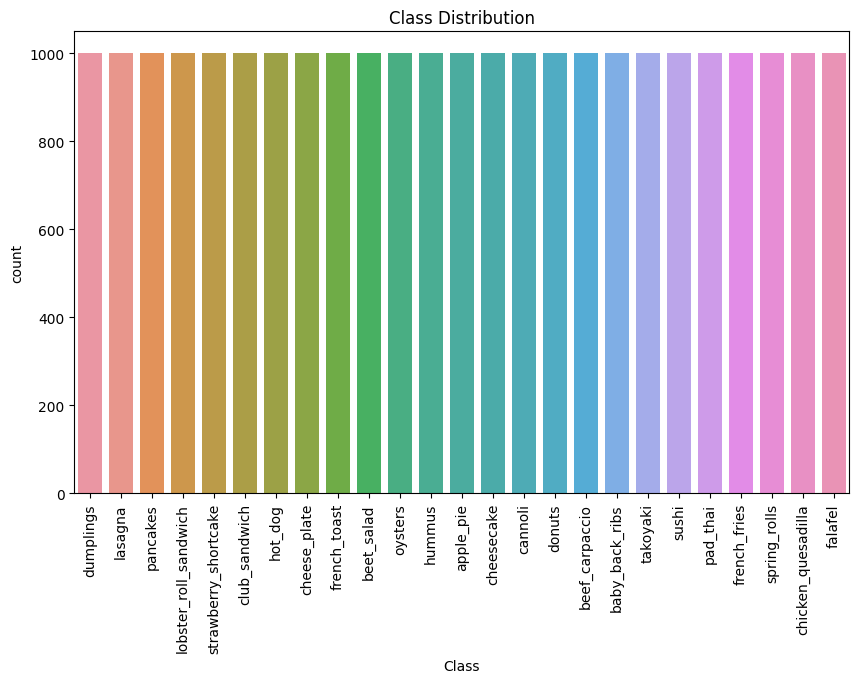

In [88]:
##Looking at distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()

It appears that the data is completely balanced

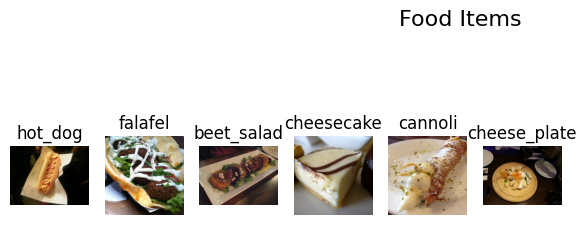

In [62]:
plt.figure(figsize=(12, 10))
sample_classes = df['Class'].sample(6, random_state=42)
for i, class_name in enumerate(sample_classes):
    img_path = df[df['Class'] == class_name]['Image'].iloc[0]
    img = Image.open(img_path)
    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Food Items', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Width', y='Height', hue='Class', palette='Set1', alpha=0.5)
plt.title('Image Size Distribution')
plt.show()

## Checking for wrongly labeled data

In [76]:
# File paths for the input files
file1_path = '/Users/ashwariyasah/Downloads/image_classification_problem/food-101/meta/test.txt'
file2_path = '/Users/ashwariyasah/Downloads/image_classification_problem/food-101/meta/train.txt'

# File path for the output (combined) file
combined_file_path = 'combined.txt'

# Read the content from file1.txt
with open(file1_path, 'r') as file1:
    content_file1 = file1.read()

# Read the content from file2.txt
with open(file2_path, 'r') as file2:
    content_file2 = file2.read()

# Combine the content from both files
combined_content = content_file1 + content_file2

# Write the combined content to the new file (combined.txt)
with open(combined_file_path, 'w') as combined_file:
    combined_file.write(combined_content)

print("Files combined successfully.")

Files combined successfully.


In [77]:
import pandas as pd

# Read the text file into a DataFrame
df_real = pd.read_csv('combined.txt', header=None, names=['type'])

print(df_real)

                     type
0       apple_pie/1011328
1        apple_pie/101251
2       apple_pie/1034399
3        apple_pie/103801
4       apple_pie/1038694
...                   ...
100995     waffles/981485
100996      waffles/98238
100997     waffles/982668
100998     waffles/995085
100999     waffles/999047

[101000 rows x 1 columns]


In [78]:
df['cleaned'] = df['Image'].str.split('/').str[-2:].str.join('/').str.replace('.jpg', '')

print(df.head())

       Class                                    Image  Width  Height  \
0  dumplings  ./food-101/images/dumplings/3010232.jpg    512     341   
1  dumplings  ./food-101/images/dumplings/1563646.jpg    512     512   
2  dumplings    ./food-101/images/dumplings/22350.jpg    512     384   
3  dumplings    ./food-101/images/dumplings/69621.jpg    512     384   
4  dumplings  ./food-101/images/dumplings/1586609.jpg    512     512   

             cleaned  
0  dumplings/3010232  
1  dumplings/1563646  
2    dumplings/22350  
3    dumplings/69621  
4  dumplings/1586609  


In [79]:
labels_images = df_real['type'].to_list()

In [80]:
# Filter mismatched rows from df_1 based on the elements in df_2
mismatched_rows_1 = df[~df['cleaned'].isin(labels_images)]

# Create a new DataFrame with the mismatched rows
mismatched_df_1 = mismatched_rows_1.copy()

print(mismatched_df_1)

Empty DataFrame
Columns: [Class, Image, Width, Height, cleaned]
Index: []


Looks like, we do not have any wronly labeled images

## Train Test Split

In [63]:
#creating two image data generators - first one for train and validation datasets and the second one for test dataset
train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)

In [64]:
#using the Keras ImageDataGenerator for image preprocessing and loading

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [65]:
df.columns

Index(['Class', 'Image', 'Width', 'Height'], dtype='object')

In [66]:
df.shape

(25000, 4)

In [67]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image',
    y_col='Class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 14000 validated image filenames belonging to 25 classes.
Found 3500 validated image filenames belonging to 25 classes.
Found 7500 validated image filenames belonging to 25 classes.


## 1. Feature Extraction with MobileNetV2

Benefits: 
Lightweight, designed for scenarios with low computation resources
Achieves a good balance between model size and accuracy



Cones:
May not achieve the same level of accuracy as deeper and more complex models like ResNet and Xception, especially on larger datasets with abundant computational resources.
Limited capacity for highly complex and multi-classification tasks due to its lightweight nature.



Using only epochs 5 to 10 because processing is taking longer than expected

Learning rate = 0.0001
Using Adam Optimiser and Catrgorical Cross Entrophy as Loss Function

In [89]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [70]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(25, activation='softmax')(x)

model_mnt = tf.keras.Model(inputs, outputs)


print(model_mnt.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_1_project (Conv2D)    (None, 56, 56, 24)           2304      ['block_1_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_1_project_BN (BatchN  (None, 56, 56, 24)           96        ['block_1_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_2_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_1_project_BN[0][0]']  
                                                                                                  
 block_2_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_2_expand[0][0]']      
 rmalization)                                                                                     
          

In [71]:
model_mnt.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [73]:
history = model_mnt.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
438/438 [==============================] - 95s 216ms/step - loss: 1.2466 - accuracy: 0.6361 - val_loss: 1.0669 - val_accuracy: 0.6777
Epoch 2/10
438/438 [==============================] - 97s 221ms/step - loss: 0.8515 - accuracy: 0.7476 - val_loss: 0.9958 - val_accuracy: 0.7000
Epoch 3/10
438/438 [==============================] - 92s 210ms/step - loss: 0.6732 - accuracy: 0.7969 - val_loss: 1.0286 - val_accuracy: 0.7083
Epoch 4/10
438/438 [==============================] - 116s 265ms/step - loss: 0.5479 - accuracy: 0.8317 - val_loss: 0.9861 - val_accuracy: 0.7180
Epoch 5/10
438/438 [==============================] - 100s 227ms/step - loss: 0.4280 - accuracy: 0.8671 - val_loss: 1.0446 - val_accuracy: 0.7114
Epoch 6/10
438/438 [==============================] - 89s 202ms/step - loss: 0.3344 - accuracy: 0.8946 - val_loss: 1.1749 - val_accuracy: 0.6946
Epoch 7/10
438/438 [==============================] - 99s 227ms/step - loss: 0.2721 - accuracy: 0.9167 - val_loss: 1.2296 - val_

In [81]:
results = model_mnt.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 71.91%


### HyperTuning on Mobilenet

##### Approach 1: Unfreezing the top layers of the model : fine-tune a small number of top layers rather than the whole MobileNet model.

In [82]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units and ReLU activation
predictions = Dense(25, activation='softmax')(x)  # Final classification layer with softmax activation

model_mnt_ft = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [83]:
# Setting the top layers as trainable
base_model.trainable = True

# To check how many layers are in the base model
print('Number of layers in the base model: ', len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [85]:
model_mnt_ft.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
history = model_mnt_ft.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
438/438 [==============================] - 144s 329ms/step - loss: 1.3103 - accuracy: 0.6279 - val_loss: 1.4120 - val_accuracy: 0.6129
Epoch 2/10
438/438 [==============================] - 144s 328ms/step - loss: 0.5198 - accuracy: 0.8461 - val_loss: 1.0693 - val_accuracy: 0.7009
Epoch 3/10
438/438 [==============================] - 147s 337ms/step - loss: 0.2484 - accuracy: 0.9289 - val_loss: 1.0164 - val_accuracy: 0.7360
Epoch 4/10
438/438 [==============================] - 139s 317ms/step - loss: 0.1124 - accuracy: 0.9686 - val_loss: 1.1514 - val_accuracy: 0.7366
Epoch 5/10
438/438 [==============================] - 137s 314ms/step - loss: 0.0554 - accuracy: 0.9851 - val_loss: 1.1000 - val_accuracy: 0.7637
Epoch 6/10
438/438 [==============================] - 152s 347ms/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 1.2379 - val_accuracy: 0.7574


In [91]:
results = model_mnt_ft.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 73.56%


##### Approach 2: Experimenting with the learning rate to find the best accuracy for the MobileNet model 

This involves training the model with different learning rate values and evaluating its performance on a validation set. 


In [94]:
# List of learning rates to experiment with
learning_rates = [1e-4, 5e-5, 1e-5, 5e-6]

for lr in learning_rates:
    # Create and compile the model with the current learning rate
    model_mnt_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model on the training data and validate on the validation data
    history = model_mnt_ft.fit(train_images, epochs=5, validation_data=val_images)
    
    # Get the best accuracy from the validation data for this learning rate
    best_val_accuracy = max(history.history['val_accuracy'])
    
    print(f"Learning Rate: {lr}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/5
438/438 [==============================] - 152s 344ms/step - loss: 0.1381 - accuracy: 0.9598 - val_loss: 1.4077 - val_accuracy: 0.7037
Epoch 2/5
438/438 [==============================] - 154s 351ms/step - loss: 0.0653 - accuracy: 0.9824 - val_loss: 1.2000 - val_accuracy: 0.7400
Epoch 3/5
438/438 [==============================] - 143s 326ms/step - loss: 0.0477 - accuracy: 0.9877 - val_loss: 1.2213 - val_accuracy: 0.7449
Epoch 4/5
438/438 [==============================] - 133s 304ms/step - loss: 0.0365 - accuracy: 0.9906 - val_loss: 1.0425 - val_accuracy: 0.7700
Epoch 5/5
438/438 [==============================] - 139s 317ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 1.1979 - val_accuracy: 0.7531


Learning Rate: 0.0001, Best Validation Accuracy: 0.7700
Epoch 1/5
438/438 [==============================] - 142s 321ms/step - loss: 0.0183 - accuracy: 0.9957 - val_loss: 1.0732 - val_accuracy: 0.7766
Epoch 2/5
438/438 [==============================] - 133s 304ms/step - loss: 0.0124 - accuracy: 0.9972 - val_loss: 1.1211 - val_accuracy: 0.7771
Epoch 3/5
438/438 [==============================] - 135s 307ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 1.1474 - val_accuracy: 0.7820
Epoch 4/5
438/438 [==============================] - 138s 314ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 1.1494 - val_accuracy: 0.7806
Epoch 5/5
438/438 [==============================] - 130s 297ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 1.1290 - val_accuracy: 0.7880


Learning Rate: 5e-05, Best Validation Accuracy: 0.7880
Epoch 1/5
438/438 [==============================] - 129s 291ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 1.0334 - val_accuracy: 0.8029
Epoch 2/5
438/438 [==============================] - 127s 290ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 1.0149 - val_accuracy: 0.8031
Epoch 3/5
438/438 [==============================] - 128s 292ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.9927 - val_accuracy: 0.8051
Epoch 4/5
438/438 [==============================] - 127s 291ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.9950 - val_accuracy: 0.8060
Epoch 5/5
438/438 [==============================] - 126s 288ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.9803 - val_accuracy: 0.8074


Learning Rate: 1e-05, Best Validation Accuracy: 0.8074
Epoch 1/5
438/438 [==============================] - 128s 289ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.9775 - val_accuracy: 0.8083
Epoch 2/5
438/438 [==============================] - 126s 288ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.9806 - val_accuracy: 0.8091
Epoch 3/5
438/438 [==============================] - 126s 288ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.9804 - val_accuracy: 0.8071
Epoch 4/5
438/438 [==============================] - 127s 290ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.9768 - val_accuracy: 0.8103
Epoch 5/5
438/438 [==============================] - 126s 288ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.9689 - val_accuracy: 0.8117
Learning Rate: 5e-06, Best Validation Accuracy: 0.8117


learning rate value of 0.000005 increses the accuracy from 71% to 81%

## 1. Feature Extraction with Xception

Benefits: 
Based on the Inception architecture but uses depthwise separable convolutions, reducing the number of parameters and operations compared to traditional convolutions.
Employs a more fine-grained feature extraction process, leading to more efficient and expressive representations.
Achieves excellent accuracy on a wide range of image classification tasks, often outperforming other architectures on certain datasets.



Cones:
More computationally intensive than MobileNet, particularly in the depthwise separable convolutional layers.
Requires more parameters than MobileNet, making it less efficient for deployment on resource-constrained devices.


In [ ]:

inception = Xception(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
# x = Dropout(0.4)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(25, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit_generator(train_images,
                    validation_data=val_images,
                    epochs=10,
                    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


/var/folders/5h/6bk9l67s2dsd0n3ptcj0n8pw0000gn/T/ipykernel_94561/2682417280.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_images,


438/438 [==============================] - 1939s 4s/step - loss: 0.6633 - accuracy: 0.8186 - val_loss: 0.7778 - val_accuracy: 0.7777
Epoch 2/10
438/438 [==============================] - 2275s 5s/step - loss: 0.2466 - accuracy: 0.9320 - val_loss: 0.7958 - val_accuracy: 0.7829
Epoch 3/10
438/438 [==============================] - 1940s 4s/step - loss: 0.1060 - accuracy: 0.9707 - val_loss: 0.9366 - val_accuracy: 0.7691
Epoch 4/10
438/438 [==============================] - 1889s 4s/step - loss: 0.0706 - accuracy: 0.9802 - val_loss: 0.8914 - val_accuracy: 0.7826


In [47]:
results = model.evaluate(test_images, batch_size=32)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


235/235 [==============================] - 212s 897ms/step - loss: 0.8215 - accuracy: 0.7711
Test Accuracy: 77.11%


## 3. Feature Extraction with ResNet50

Benefits: 
Residual connections allow for better information flow through the network, resulting in improved performance on large-scale and complex datasets.
Shows impressive generalization capabilities, leading to high accuracy on various image classification tasks


Cones:
May not achieve the same level of accuracy as deeper and more complex models like ResNet and Xception, especially on larger datasets with abundant computational resources.
Limited capacity for highly complex and multi-classification tasks due to its lightweight nature.

Deeper ResNet models can be computationally expensive and memory-intensive during training.
May require more data and computational resources for successful training compared to smaller architectures like MobileNet.

Using only epochs 5 to 10 because processing is taking longer than expected

Learning rate = 0.01
Using Adam Optimiser and Catrgorical Cross Entrophy as Loss Function

In [95]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = resnet.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units and ReLU activation
predictions = Dense(25, activation='softmax')(x)  # Final classification layer with softmax activation

In [96]:
model_res = Model(inputs=resnet.input, outputs=predictions)

In [97]:
model_res.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
history = model_res.fit_generator(train_images,
                    validation_data=val_images,
                    epochs=10,
                    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

/var/folders/5h/6bk9l67s2dsd0n3ptcj0n8pw0000gn/T/ipykernel_94561/2752683797.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_res.fit_generator(train_images,


Epoch 1/10
 85/438 [====>.........................] - ETA: 18:57 - loss: 3.1382 - accuracy: 0.0610

In [ ]:
results = model_res.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

## Plotting feature maps for Finalized Model


feature maps are intermediate representations of the input image that are obtained after applying convolutional operations. These maps highlight specific patterns and features found in the image. 

In [121]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [119]:
# fetching layer names from
layer_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu']



In [129]:
feature_map_model = tf.keras.Model(inputs=base_model.input, outputs=[base_model.get_layer(name).output for name in layer_names])


In [124]:
image = tf.keras.preprocessing.image.load_img('/Users/ashwariyasah/Downloads/image_classification_problem/food-101/images/spring_rolls/3920184.jpg', target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = tf.keras.applications.mobilenet_v2.preprocess_input(image_array)


1/1 [==============================] - 0s 29ms/step


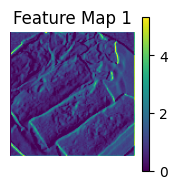

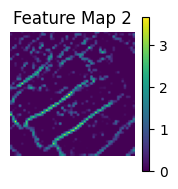

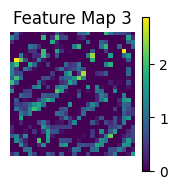

In [127]:
# Get the feature maps for the input image
feature_maps = feature_map_model.predict(image_array)

# Plot the feature maps
for i, fm in enumerate(feature_maps):
    plt.figure(figsize=(2, 2))
    plt.imshow(fm[0, :, :, 0], cmap='viridis')  # Visualize the first channel of the feature map
    plt.title(f"Feature Map {i + 1}")
    plt.colorbar()
    plt.axis('off')

plt.show()

In [131]:
## saving mobilenet model

# Save the model as an .h5 file
model_mnt_ft.save('mobilenet_with_tuning.h5')

/Users/ashwariyasah/Downloads/image_classification_problem/myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
